In [260]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense
from lava.proc.spiker.process import Spiker
from lava.proc.monitor.process import Monitor
from lava.proc.io.source import RingBuffer
from lava.magma.core.run_conditions import RunSteps, RunContinuous
from lava.magma.core.run_configs import Loihi1SimCfg
import numpy as np

num_steps = 10

In [261]:
def get_input_buffer(genome):
    buffer_data = np.concatenate((np.array(genome), np.zeros(num_steps)))
    
    return RingBuffer(data=np.array([buffer_data]))


def create_neuron(name, threshold=0.999):
    neuron = LIF(shape=(1, ),                         # Number and topological layout of units in the process
           vth=threshold,                              # Membrane threshold
           dv=0,                              # Inverse membrane time-constant
           du=1,                              # Inverse synaptic time-constant
           bias_mant=0.0,              # Bias added to the membrane voltage in every timestep
           name=name)
    
    return neuron
    
def connect_neurons(neuron1, neuron2, weight=1.0, delay=1):
    # add possible delay neurons
    input_neuron = neuron1
    
    conn = Dense(weights=np.array([[weight]]), name='conn')
    neuron1.s_out.connect(conn.s_in)
    
    for i in range(delay - 1):
        conn_delay = Dense(weights=np.array([[weight]]), name='conn_delay')
        conn.a_out.connect(conn_delay.s_in)
        conn = conn_delay
        print(i)
        
    # add dense if weight != 1
    conn.a_out.connect(neuron2.a_in)

In [262]:
input_Aa = get_input_buffer([1,0,0,0,0,0,0,0,0,0])
input_Ab = get_input_buffer([0,0,0,0,0,0,0,0,0,0])
input_Ac = get_input_buffer([1,0,0,0,0,0,0,0,0,0])
input_Ba = get_input_buffer([1,0,0,0,0,0,0,0,0,0])
input_Bb = get_input_buffer([1,0,0,0,0,0,0,0,0,0])
input_Bc = get_input_buffer([1,0,0,0,0,0,0,0,0,0])


neuron_IAa = create_neuron('IAa', threshold=0.999)
neuron_IAb = create_neuron('IAb', threshold=0.999)
neuron_IAc = create_neuron('IAc', threshold=0.999)
neuron_IBa = create_neuron('IBa', threshold=0.999)
neuron_IBb = create_neuron('IBb', threshold=0.999)
neuron_IBc = create_neuron('IBc', threshold=0.999)

connect_neurons(input_Aa, neuron_IAa, weight=1, delay=1)
connect_neurons(input_Ab, neuron_IAb, weight=1, delay=1)
connect_neurons(input_Ac, neuron_IAc, weight=1, delay=1)
connect_neurons(input_Ba, neuron_IBa, weight=1, delay=1)
connect_neurons(input_Bb, neuron_IBb, weight=1, delay=1)
connect_neurons(input_Bc, neuron_IBc, weight=1, delay=1)

acc = create_neuron('acc', threshold=0.999)
connect_neurons(neuron_IAa, acc, weight=-1, delay=1)
connect_neurons(neuron_IAb, acc, weight=-1, delay=1)
connect_neurons(neuron_IAc, acc, weight=-1, delay=1)
connect_neurons(neuron_IBa, acc, weight=1, delay=1)
connect_neurons(neuron_IBb, acc, weight=1, delay=1)
connect_neurons(neuron_IBc, acc, weight=1, delay=1)

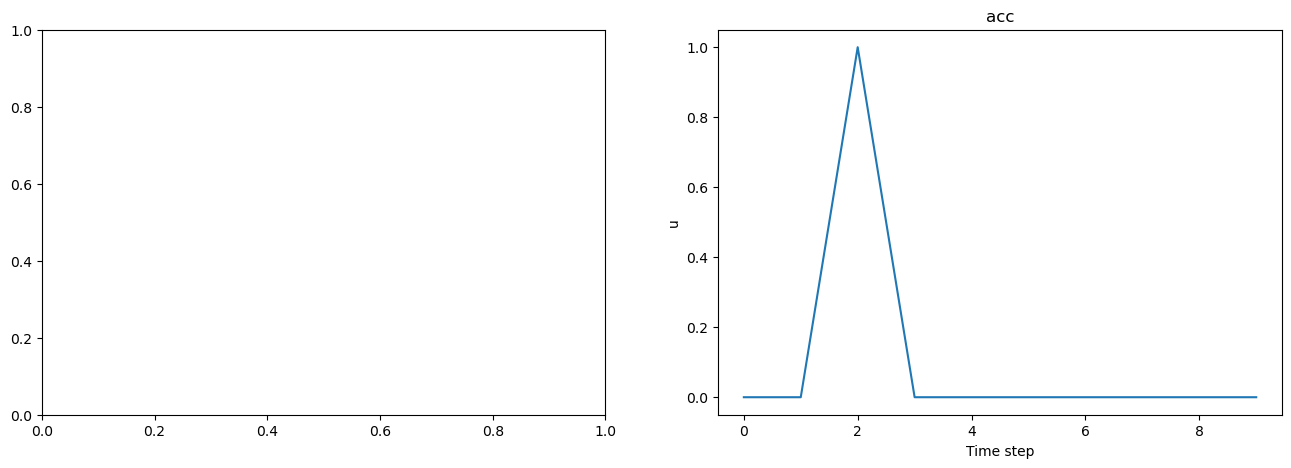

In [263]:
monitor_out = Monitor()
#monitor_lif1.probe(lif1.v, num_steps)
monitor_out.probe(acc.u, num_steps)

# run conditions
run_condition = RunSteps(num_steps=num_steps)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")

# run network and get results
acc.run(condition=run_condition, run_cfg=run_cfg)
#data_lif1 = monitor_lif1.get_data()
data_out = monitor_out.get_data()

# plot results
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitor
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the recorded data
#monitor_lif1.plot(ax0, lif1.v)
monitor_out.plot(ax1, acc.u)